## Notes

Diminuer le pas, va marcher mais trop long
gradient amorti, gradient à pas optimal

c1 = 10^-4, c2 = 0.9

Style de rendu ?

Questions
- q6 manque une composante vecteur c, alpha non négligeable ?
- q7 max coût ou profit ?
- q8 norme non différentiable en 0 ?
- calculer gradient à la main ou autograd ? besoin pour scipy ? problème décompose vecteur z...
- deux algorithmes à trouver... : newton avec pénalisation (mais pas dans le cours ?) et gradient proximal ?
- vérifier avec scipy (ou à utiliser ?), quel choix de méthode ? calcul gradient des fonctions & des coûts ?
- scipy à la fin : production négative : rajouter des contraintes
- résultat pas entier : moitié de croissant ? où arrondir ?
- résultat différent : mauvaise valeur de alpha... ? à quoi s'attendre ?
- grande variabilité selon la valeur de alpha ? bizarre première méthode... ou problème scipy slsqp sans gradient spécifié (important) ?


In [19]:
import numpy as np
from scipy import optimize
import casadi
from casadi import SX, mtimes, transpose, exp, sum1, fmin, MX
np.set_printoptions(suppress=True)

## 1. Etude du problème d'optimisation

### Question 1

Le coût (2) correspond au profit de la boulangerie :

- $c^T r$ est le coût d'achat des matières premières
- $v^T q$ est le montant rapporté par la vente d'une quantité de produits $q$ (tout ce qui a été produit)
- $v^T d$ est le montant rapporté par la vente d'une quantité de produits $d$ (tout ce qui a été demandé)

Ainsi, le terme $\min\{q,d\}$ correspond à la quantité minimum entre ce qui a été produit ou demandé. En effet, le facteur limitant des gains dépend si la demande est supérieure à la production ou si la production est supérieure à la demande (dans le cas d'économies d'échelle par exemple, cela peut être rentable).


### Question 2

Ce terme avec un $\min$ n'est pas un opérateur linéaire, il n'est donc peut-être pas différentiable et ne permet pas d'appliquer les méthodes du cours les plus efficaces.

### Question 3

Cette formule fait penser à la statistique de Maxwell-Boltzmann.

Soit $i \in [|1, p|]$.

Cas 1 : $q_i > d_i$. Montrons que $h_i \approx d_i$.

$\exp(-\alpha q_i) << \exp(-\alpha d_i)$ et $q_i \exp(-\alpha q_i)$ est toujours petit devant $d_i \exp(-\alpha d_i)$ car $\alpha >> 1$, ce qui permet de simplifier et d'obtenir le résultat.

Cas 2 : $q_i < d_i$. On procède de manière similaire par symétrie

On a donc maintenant une fonction convexe différentiable ce qui permet de se placer dans un cadre où l'on dispose plus de résultats.

### Question 4

On suppose que $d$ est fixé. On pose :

- $z = (q, r)$ (de taille $n=p + m$)
- $f(z) = f(q, r) = c^T r - v^T h(q, d)$, à valeurs dans $\mathbb{R}$
- $c(z) = c(q, r) = A q - r$ ($m$ contraintes)

## 2. Etude et résolution numérique

### Question 5

Puisque la fonction $f$ est deux-fois différentiable, on peut utiliser la méthode la plus efficace pour l'optimisation différentiable, c'est-à-dire la méthode de Newton. Toutefois, il faut prendre en compte les contraintes inégalités. On peut donc penser à une optimisation avec pénalités.

Une autre approche serait les algorithmes d'optimisiation différentiable sous contraintes, comme celui Uzawa ou d'Arrow-Hurwicz (les contraintes sont linéaires)

### Question 6

Il est surprenant que $1$ ne soit pas négligeable devant $\alpha$...

In [20]:
def q6(a=0.1):
    alpha = a
    c = 1e-3*np.array([30.,1.,1.3,4., 1.])
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)
print(n)

8


In [21]:
def fun_hp(q, d, alpha=alpha):
    return (q*exp(-alpha*q)+d*exp(-alpha*d))/(exp(-alpha*q)+exp(-alpha*d))

In [22]:
k = len(d)

opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), fun_hp(q, dp))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x,x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}}
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

sol = opti.solve();
print(sol.value(x))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

[   402.12704191     73.10746942     42.43483578   1596.09442137
 107441.22892767    712.1642646    3348.6471351     621.41349253]


In [23]:
def fun_h(q, d, alpha=alpha):
    return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))

print(fun_h(np.array([1.,2.,3.]), d))

def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
    q = z[:len(d)]
    r = z[len(d):]
    return c.T @ r - v.T @ fun_h(q, d, alpha)

ztest = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
print(fun_f(ztest))

def fun_c(z, A=A):
    q = z[:len(d)]
    r = z[len(d):]
    return A @ q - r

print(c)

[1.         2.09757685 4.4227762 ]
-8.742619084891563
[0.03   0.001  0.0013 0.004  0.001 ]


In [24]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -333.5215778545896
            Iterations: 65
            Function evaluations: 593
            Gradient evaluations: 65
[   402.12901883     73.11143238     42.43397464   1596.10840532
 107442.01866487    712.19338296   3348.79704161    621.44717523]


<ipython-input-25-5c11035186b9>:12: RuntimeWarning: overflow encountered in exp
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))
<ipython-input-25-5c11035186b9>:12: RuntimeWarning: invalid value encountered in true_divide
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


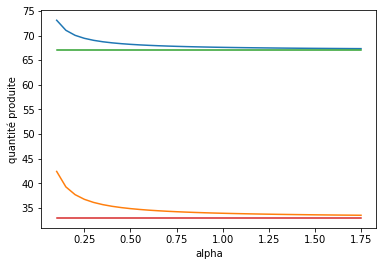

In [25]:
# avec différents alpha

import matplotlib.pyplot as plt

baguettes_list, chocolats_list, croissants_list = [], [], []
alphas = np.arange(0.1, 1.8, 0.05)

for a in alphas:
    n, alpha, c, v, d, A = q6(a)
    
    def fun_h(q, d, alpha=alpha):
        return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


    def fun_f(z, d=d, A=A, c=c, v=v, alpha=alpha):
        q = z[:len(d)]
        r = z[len(d):]
        return c.T @ r - v.T @ fun_h(q, d, alpha)

    def fun_c(z, A=A):
        q = z[:len(d)]
        r = z[len(d):]
        return A @ q - r

    ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
    res = optimize . minimize(fun_f, x0, method= 'SLSQP' ,
    constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})
    
    baguettes, chocolats, croissants = res.x[:3]
    baguettes_list.append(baguettes)
    chocolats_list.append(chocolats)
    croissants_list.append(croissants)

plt.figure()
#plt.plot(alphas, baguettes_list)
plt.plot(alphas, chocolats_list)
plt.plot(alphas, croissants_list)
#plt.plot(alphas, 400*np.ones(len(alphas)))
plt.plot(alphas, 67*np.ones(len(alphas)))
plt.plot(alphas, 33*np.ones(len(alphas)))
plt.xlabel("alpha")
plt.ylabel("quantité produite")
plt.show()


La valeur de la fonction de coût est négative, donc l'entreprise fait des profits.

On observe que les quantités produites sont toujours supérieures aux quantités demandées, ce qui est surprenant car le modèle ne permet pas les économies d'échelle a priori.

Cela pourrait donc être notre approximation du minimum qui serait en cause. Pour le vérifier, nous avons représenté les quantités produites selon la valeur du paramètre $\alpha$. Lorsqu'il augmente, c'est-à-dire lorsque notre approximation "se rapproche" de la fonction $\min$, on observe bien que les quantités produites tendent vers les quantités demandées par valeurs supérieures, ce qui confirme cette hypothèse. On peut donc conclure que la quantité optimale est la quantité demandée avec ces paramètres.

On peut également comparer aux résultats obtenus dans la dernière partie du problème.

### Question 7

a. Problème d'optimisation.

On calcule l'espérance de l'opposé du profit : $E(z)=\pi_1 f_1(z)+\pi_2 f_2(z)+\pi_3 f_3(z)$ où $f_i(z)= c^T r - v^T h(q, d^i)$

On minimise donc cette quantité $E(z)$ avec les mêmes contraintes.



In [26]:
def q7():
    d1 = np.array([400., 67., 33.])
    d2 = np.array([500., 80., 53.])
    d3 = np.array([300., 60., 43.])
    p1 = 0.5
    p2 = 0.3
    p3 = 0.2
    return d1, p1, d2, p2, d3, p3

ps = q7()
d1, p1, d2, p2, d3, p3 = q7()


In [27]:
def fun_E(z, ps=ps):
    d1, p1, d2, p2, d3, p3 = ps
    return p1*fun_f(z, d1)+p2*fun_f(z, d2)+p3*fun_f(z, d3)

In [28]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})

print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -318.64111227006396
            Iterations: 80
            Function evaluations: 774
            Gradient evaluations: 80
[   400.38246532     79.75447662     53.23546479   1614.08304665
 107806.8610795     797.74220733   3722.53371271    677.91305127]


<ipython-input-25-5c11035186b9>:12: RuntimeWarning: overflow encountered in exp
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))
<ipython-input-25-5c11035186b9>:12: RuntimeWarning: invalid value encountered in true_divide
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


In [29]:

opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(3, k)
pp = opti.parameter(k)
ap = opti.parameter(n-k,k)

f = 0
for j in range(3):
    f += pp[j]*(mtimes(transpose(cp), r) - mtimes(transpose(vp), fun_hp(q, transpose(dp[j,:]))))

opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x,x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}}
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(ap, A)
opti.set_value(pp, [p1, p2, p3])
opti.set_value(dp, np.array([d1, d2, d3]))

sol = opti.solve();
print(sol.value(x))
print(fun_E(sol.value(x)))

[   406.69842673     77.13921035     54.28956029   1632.01247461
 109202.9825197     779.98236557   3628.46401742    655.68329044]
-317.5732629587021


Produit un peu plus pour couvrir la variabilité si plus de demande car proba plus de demande plus importante que demande plus faible ?

Comparer aussi la valeur du profit en lui-même...

### Question 8

a. On suppose que $r$ et $d$ sont fixés. On a toujours le terme de revenus $v^T h(q,d)$. Cependant les achats de matières premières ayant déjà été réalisés, on ne cherche plus à savoir combien en acheter mais comment utiliser celles que l'on a au mieux.
Or les matières premières sont supposées réutilisables le lendemain tandis que les produits ne peuvent être vendus le lendemain. De plus on a vu en 6) et 7) que le plus profitable était de satisfaire la demande. Dès lors, on cherche à minimiser $\lVert d-q \rVert$ afin de satisfaire le plus de clients possible ($d-q$ le plus proche de 0 possible par valeur supérieure) et afin d'éviter le gaspillage ($q-d$ le plus proche de 0 possible par valeur supérieure).

Le terme $\lVert d-q \rVert^2$ convient donc, et a en plus la bonne propriété d'être différentiable.  
   

b. 

In [30]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_c(x)}
res = optimize . minimize(fun_E, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})

y = res.x
print('qté planifiée', y[:3])
rsave = y[len(d):]
#print(y)
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[2], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d) # attention norme au carré

def fun_cb(q, r=r, d=ps[2]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})

print('demande forte', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[0], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d) # attention norme au carré

def fun_cb(q, r=r, d=ps[0]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})

print('demande moyenne', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))

def fun_g(q, d=ps[4], v=v):
    return (q-d).T @ (q-d) - v.T @ fun_h(q, d) # attention norme au carré

def fun_cb(q, r=r, d=ps[4]):
    return fun_c(np.hstack((q, r)))

ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_g, y0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : False, 'maxiter': 10000})

print('demande faible', res.x[:3])
r = y[len(d):]
y0 = np.zeros(len(d))




qté planifiée [400.38246532  79.75447662  53.23546479]
demande forte [410.1789162   51.86322745  44.52295333]
demande moyenne [400.16239195  67.22904759  33.18657357]
demande faible [300.16239419  60.22881     43.18682111]


<ipython-input-25-5c11035186b9>:12: RuntimeWarning: overflow encountered in exp
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))
<ipython-input-25-5c11035186b9>:12: RuntimeWarning: invalid value encountered in true_divide
  return (q*np.exp(-alpha*q)+d*np.exp(-alpha*d))/(np.exp(-alpha*q)+np.exp(-alpha*d))


In [31]:

opti = casadi.Opti();

q = opti.variable(k)
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)
rp = opti.parameter(n-k)

f = mtimes(transpose(q-dp), q-dp) - mtimes(transpose(vp), fun_hp(q, dp))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - rp <= 0)

x0 = np.array([0.]*k)
opti.set_initial(q,x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}}
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, ps[4])
opti.set_value(ap, A)
opti.set_value(rp, r)

sol = opti.solve();
print(sol.value(q))

[300.22004929  60.36144863  43.26764076]


## 3. Etude du problème non-régularisé

### Question 9

Méthode de gradient proximale (optimisation non-différentiable ?) (cf Traitement du Signal ?)

### Question 10

In [32]:
def fun_hb(q, d, alpha=alpha):
    return np.minimum(q,d)

print(fun_hb(np.array([1.,2.,3.]), d))

def fun_fb(z, d=d, A=A, c=c, v=v, alpha=alpha):
    q = z[:len(d)]
    r = z[len(d):]
    return c.T @ r - v.T @ fun_hb(q, d, alpha)

def fun_cb(z, A=A):
    q = z[:len(d)]
    r = z[len(d):]
    return np.hstack((A @ q - r,-q))

ztest = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
print(fun_fb(ztest))

[1. 2. 3.]
-7.0312


In [26]:
ineq_cons = { 'type' : 'ineq' , 'fun' : lambda x: - fun_cb(x)}
res = optimize . minimize(fun_fb, x0, method= 'SLSQP' ,
constraints= [ineq_cons], options={ 'disp' : True, 'maxiter': 10000})
print(res.x)

# résultat fantasiste : méthode de scipy pas adaptée au problème ? profit positif car opposé du résultat...
# SLSQP pourtant OK pour non linéaire ? problème gradient ?
# problème alpha ?

# pas possible production négative ?? rajout d'une contrainte : fun_cb

ValueError: operands could not be broadcast together with shapes (5,) (0,) 

Résultat assez différents (quantifier ?) : normal ou non ?

In [60]:

def q6():
    alpha = 0.1
    c = 1e-3*np.array([30.,1.,1.3,4., 1.])
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)
print(n)

8


In [133]:
k = len(d)

opti = casadi.Opti();

x = opti.variable(n)
q = x[0:k]
r = x[k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)

# contrainte, q & r positives

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), fmin(q,d)) + 1e7*casadi.dot(q-d, q-d)# normaliser le problème ou adapter les paramètres 0.00002067, connaitre ordre de grandeur de q - d(casadi.dot(q-d, q-d)+casadi.dot(r, r))
opti.minimize(f)
opti.subject_to(mtimes(ap, q) - r <= 0)
opti.subject_to( - r <= 0)
opti.subject_to( - q <= 0)

x0 = np.array([0.]*n)
opti.set_initial(x, x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}}
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
except:
    print("erreur")
    print(opti.debug.value)

[   400.             67.00000002     33.00000002   1567.00033459
 106185.01003891    635.00771989   3010.00250994    569.51003579]


min de l'espérance q7 attention
3 lignes  problème bien posé

min (q,d) 
probabilité



In [121]:
convexe, non convexe, contraintes ou non, pas besoin d'être exhaustif
tp4 utile pour le miniprojet

SyntaxError: invalid syntax (<ipython-input-29-633ea57a3fc7>, line 1)

In [122]:
écrire le problème non différentielle
transformation du problème : rajouter des contraintes qui reproduise le problème là

problème équivalent : variable équivalent, toutes les variables est dériables

problème linéaire sauf le min
méthode basée dérivée

que pas contrainte solution car linéaire

gradient toujours le même

conditions de KKT

méthode basée sur la dérivée
méthode de gradient

régulariser : alpha q^2

toutes acceptables

imagination,
toutes les méthodes basées sur la dérivée vont échouée


sans le min: résoudre chaque problème


SyntaxError: invalid syntax (<ipython-input-30-f52f0e37b0f9>, line 1)

Discussion avec le prof:
utiliser np.dot(q, q) pour norme de q au carré
mtimes vérifier pas pour mult element par element

q7 : min(q, r) de E_d(v^t*h()-...)
écrire ainsi

2 solutions pour q10 : gradient proximal (sous différentiel) : normaliser en rajoutant + alpha * np.dot(q, q) + alpha * np.dot(r,r) et faire tendre alpha vers 0... voir si cela se passe bien

OU décomposer avec contrainte
production = q + s avec s = slack (vendu à coût nul si production supérieur à la demande) et q vendu à coût non nul
contrainte  q <= d 
et pour que s soit nul si q <= d, contrainte de complémentarité s(q-d)=0
et enlever le min, à faire avec casadi

enfin, chercher un résultat entier (contrainte en plus pour casadi)
ou écrire que x = sum(n_i y_i) avec n_i = 1, 2, ... et y_i dans [0, 1] avec contrainte sum(y_i) <= 1 ???

In [134]:

def q6():
    alpha = 0.1
    c = 1e-3*np.array([30.,1.,1.3,4., 1.]) # seuil 3.2
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)
print(n)

k = len(d)

opti = casadi.Opti();

x = opti.variable(n+k)
q = x[0:k]
s = x[k:2*k]
r = x[2*k:]
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)


# au carré ?

# contrainte, q & r positives

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), q)
opti.minimize(f)
opti.subject_to(mtimes(ap, q + s) - r <= 0)
opti.subject_to( - r <= 0)
opti.subject_to( - q <= 0)
opti.subject_to( - q <= 0)
#opti.subject_to( - s <= 0)
#opti.subject_to(casadi.ceil(q)==q)
opti.subject_to( q - d <= 0)
opti.subject_to( s*(q - d) == 0)

x0 = np.array([0.]*(n+k))
opti.set_initial(x,x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}} #discrete = Ture
#https://www.google.com/search?q=ipopt+discrete+variable&rlz=1C1CHBF_frFR904FR904&oq=ipopt+discrete+variable&aqs=chrome..69i57.3663j0j7&sourceid=chrome&ie=UTF-8
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(dp, d)
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
except:
    print("erreur")
    print(opti.debug.value)

8
[   400.00000001     67.00000001     33.00000001     -0.
     -0.             -0.           1567.00000012 106185.00000466
    635.000002     3010.00000101    569.50000256]


In [ ]:
Pas besoin d'entiers car variations lentes, pas de variations entre parties entières.

In [ ]:
A = np.array([])
A= casadi.MX(A)
eA = casadi.exp(A)

In [163]:

def q6():
    alpha = 0.1
    c = 1e-3*np.array([30.,1.,1.3,4., 1.]) # seuil 3.2
    v = np.array([0.9, 1.5, 1.1])
    d = np.array([400., 67., 33.])
    A = np.array([[3.5,2.,1.],[250.,80., 25.],[0., 8., 3.],[0., 40., 10.], [0., 8.5, 0.]])
    n = len(c)+len(d)
    return n, alpha, c, v, d, A

n, alpha, c, v, d, A = q6()
x0 = np.zeros(n)
print(n)

k = len(d)

opti = casadi.Opti();

x = opti.variable(2*k)
q = x[0:k]
s = x[k:2*k]
r = opti.parameter(n-k)
cp = opti.parameter(n-k)
vp = opti.parameter(k)
dp = opti.parameter(k)
ap = opti.parameter(n-k,k)


# au carré ?

# contrainte, q & r positives

f = mtimes(transpose(cp), r) - mtimes(transpose(vp), q)
opti.minimize(f)
opti.subject_to(mtimes(ap, q + s) - r <= 0)
opti.subject_to( - q <= 0)
#opti.subject_to( - s <= 0)
#opti.subject_to(casadi.ceil(q)==q)
opti.subject_to( q - dp <= 0)
opti.subject_to( s*(q - dp) == 0)

x0 = np.array([0.]*(2*k))
opti.set_initial(x,x0)
# pour enlever le blabla, définir un dictionnaire d'option
options = {'print_time':False, 'ipopt':{'print_level':0}} #discrete = Ture
#https://www.google.com/search?q=ipopt+discrete+variable&rlz=1C1CHBF_frFR904FR904&oq=ipopt+discrete+variable&aqs=chrome..69i57.3663j0j7&sourceid=chrome&ie=UTF-8
# options = dict(print_time=False, ipopt=dict(print_level=0))
opti.solver('ipopt', options);


opti.set_value(cp, c)
opti.set_value(vp, v)
opti.set_value(r, rsave)
opti.set_value(dp, ps[4])
opti.set_value(ap, A)

try:
    sol = opti.solve();
    print(sol.value(x))
    print(sol.value(f))
except:
    print("erreur")
    print(opti.debug.value)

8
[300.00000001  60.00000001  43.00000001  -0.          -0.
   0.        ]
-234.46622248953173


In [ ]:
# normaliser 